## 1. Exploratory Data Analysis (EDA) – Brazilian Soybean Price Forecasting with SARIMAX

This notebook conducts a comprehensive exploratory data analysis to prepare inputs for a SARIMAX model that forecasts Brazilian Paranaguá Soybean Prices (metric ton). It combines WASDE supply and demand data for both soybean and corn (Brazil and U.S.), along with average futures price movements between reports. We analyze trends, seasonality, correlation, and stationarity before model training.


In [3]:
# ──────────────────────────────────────────────────────────────
# 📦 Imports - Core Modules and Data Science Stack
# ──────────────────────────────────────────────────────────────
import sys
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ──────────────────────────────────────────────────────────────
# 📊 Time Series Analysis Tools (Statsmodels)
# ──────────────────────────────────────────────────────────────
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ──────────────────────────────────────────────────────────────
# 🔧 Project Configuration
# ──────────────────────────────────────────────────────────────
sys.path.append(str(Path().resolve().parent / "src"))
from config import (
    CORN_QUOTES,
    SOYBEAN_QUOTES,
    SOYBEAN_PREMIUM_QUOTES,
    CORN_CURRENT,
    CORN_OUTLOOK,
    SOYBEAN_CURRENT,
    SOYBEAN_OUTLOOK,
    MODEL_SOYBEAN,
)

from eda_utils import prepare_modeling_data, test_lagged_correlation, top_lagged_predictors

### 2. Load Raw Data

We load the core datasets required to build the modeling dataset:

- **WASDE Reports**:
  - Current year (`CY`) and outlook year (`OY`) data for both corn and soybean.
  - These contain production, exports, and ending stocks information for Brazil and the United States.

- **Futures Prices**:
  - Daily soybean prices will serve as exogenous variables to help explain corn price variation.
  - Daily corn prices represent the target variable to be predicted.

Each dataset will be cleaned, merged, and aggregated in the following steps.


In [4]:
# ──────────────────────────────────────────────────────────────
# 📥 Load Data – WASDE Features and Futures Quotes
# ──────────────────────────────────────────────────────────────

# WASDE-based features (CY and OY for corn and soybean)
df_corn_current     = pd.read_excel(CORN_CURRENT)
df_corn_outlook     = pd.read_excel(CORN_OUTLOOK)
df_soybean_current  = pd.read_excel(SOYBEAN_CURRENT)
df_soybean_outlook  = pd.read_excel(SOYBEAN_OUTLOOK)

# Soybean futures prices (to compond the target variable)
df_soybean_quotes   = pd.read_excel(SOYBEAN_QUOTES)
df_soybean_premium_quotes = pd.read_excel(SOYBEAN_PREMIUM_QUOTES)

# Corn futures prices (feature)
df_corn_quotes      = pd.read_excel(CORN_QUOTES)


### 3. Column Selection and Data Merging

To reduce dimensionality and focus on the most relevant economic indicators, we manually select key features from each WASDE dataset:

- **Production, exports, and ending stocks** for corn and soybeans
- For both **Brazil and the United States**
- For both **current year (CY)** and **outlook year (OY)** reports

We also:
- Standardize column names for price quotes
- Merge the WASDE datasets using the `report_date`
- Merge corn and soybean futures quotes using the `date` column

This results in two main DataFrames:
- `df_wasde`: monthly WASDE features aligned by report date
- `df_quotes`: daily futures prices for corn and soybean


In [5]:
# ──────────────────────────────────────────────────────────────
# 🧹 Select Relevant Columns and Standardize Structure
# ──────────────────────────────────────────────────────────────

# Select relevant features from each WASDE dataset
df_corn_current = df_corn_current[
    [
        "report_date",
        "production_corn_cy_brazil",
        "production_corn_cy_unitedstates",
        "exports_corn_cy_brazil",
        "exports_corn_cy_unitedstates",
        "ending_stocks_corn_cy_brazil",
        "ending_stocks_corn_cy_unitedstates",
    ]
]

df_corn_outlook = df_corn_outlook[
    [
        "report_date",
        "production_corn_oy_brazil",
        "production_corn_oy_unitedstates",
        "exports_corn_oy_brazil",
        "exports_corn_oy_unitedstates",
        "ending_stocks_corn_oy_brazil",
        "ending_stocks_corn_oy_unitedstates",
    ]
]

df_soybean_current = df_soybean_current[
    [
        "report_date",
        "production_soybean_cy_brazil",
        "production_soybean_cy_unitedstates",
        "exports_soybean_cy_brazil",
        "exports_soybean_cy_unitedstates",
        "ending_soybean_cy_brazil",
        "ending_soybean_cy_unitedstates",
    ]
]

df_soybean_outlook = df_soybean_outlook[
    [
        "report_date",
        "production_soybean_oy_brazil",
        "production_soybean_oy_unitedstates",
        "exports_soybean_oy_brazil",
        "exports_soybean_oy_unitedstates",
        "ending_soybean_oy_brazil",
        "ending_soybean_oy_unitedstates",
    ]
]

# Standardize quote columns
df_soybean_quotes = df_soybean_quotes.rename(columns={"Date": "date", "CLOSE": "soybean_quote"})
df_soybean_premium_quotes = df_soybean_premium_quotes.rename(columns={"Date": "date", "CLOSE": "soybean_premium"})
df_corn_quotes = df_corn_quotes.rename(columns={"Date": "date", "CLOSE": "corn_quote"})

# Merge WASDE datasets by report date
df_wasde = pd.merge(df_corn_current, df_corn_outlook, on="report_date", how="inner")
df_wasde = pd.merge(df_wasde, df_soybean_current, on="report_date", how="inner")
df_wasde = pd.merge(df_wasde, df_soybean_outlook, on="report_date", how="inner")

# Merge quote datasets by daily date
df_quotes = pd.merge(df_soybean_quotes, df_soybean_premium_quotes, on="date", how="inner")
df_quotes = pd.merge(df_quotes, df_corn_quotes, on="date", how="inner")


### 4. Preview Merged Datasets

We now preview the two main merged datasets:

- **`df_quotes`**: Contains daily futures prices for corn (target) and soybean (exogenous feature), matched by date.
- **`df_wasde`**: Contains monthly WASDE fundamentals (production, exports, ending stocks) for both crops and both countries, matched by report date.

These datasets will be aligned and aggregated in the next step to generate the modeling dataset.


In [6]:
display(df_quotes.head())

display(df_wasde.head())

,date,soybean_quote,soybean_premium,corn_quote
0,2004-02-19,880.00,-85,284.75
1,2004-02-20,893.00,-105,284.75
2,2004-02-25,933.75,-120,291.75
3,2004-02-26,928.00,-115,296.00
4,2004-02-27,942.50,-115,296.25


,report_date,production_corn_cy_brazil,production_corn_cy_unitedstates,exports_corn_cy_brazil,exports_corn_cy_unitedstates,ending_stocks_corn_cy_brazil,ending_stocks_corn_cy_unitedstates,production_corn_oy_brazil,production_corn_oy_unitedstates,exports_corn_oy_brazil,...,exports_soybean_cy_brazil,exports_soybean_cy_unitedstates,ending_soybean_cy_brazil,ending_soybean_cy_unitedstates,production_soybean_oy_brazil,production_soybean_oy_unitedstates,exports_soybean_oy_brazil,exports_soybean_oy_unitedstates,ending_soybean_oy_brazil,ending_soybean_oy_unitedstates
0,2010-07-09,51.0,307.14,7.14,47.18,12.08,42.5,51.0,336.44,7.0,...,29.99,34.93,12.04,3.76,65.0,91.04,28.9,37.29,18.40,9.80
1,2010-08-12,51.0,307.14,7.14,46.97,12.08,42.5,51.0,339.49,7.0,...,29.99,34.82,12.04,3.76,65.0,93.44,29.4,39.05,16.47,9.80
2,2010-09-10,51.0,307.14,7.14,46.97,12.08,42.5,51.0,334.27,7.0,...,29.99,34.82,12.04,3.76,65.0,94.79,30.4,40.42,15.37,9.51
3,2010-10-08,51.0,307.14,7.14,46.97,12.08,42.5,51.0,321.68,7.0,...,29.99,34.82,12.04,3.76,67.0,92.76,31.4,41.37,15.85,7.20
4,2010-11-09,51.0,307.14,7.14,46.97,12.08,42.5,51.0,318.52,7.0,...,29.99,34.82,12.04,3.76,67.5,91.85,31.4,42.73,15.84,5.03


### 5. Build Modeling Dataset: Align WASDE Reports with Price Windows

The WASDE reports are published monthly, while corn and soybean prices are available on a daily basis.  
To properly align the target variable (`soybean`) with the explanatory features:

- We calculate the **average daily price** of corn and soybean between each pair of consecutive WASDE report dates.
- The average prices are then assigned to the **second** of each WASDE pair, representing what the market experienced **after** the previous report and **before** the current one.

This aggregation ensures no future data leakage and reflects the information that would have been available at each report date.


In [7]:
df_model = prepare_modeling_data(raw_wasde=df_wasde, raw_quotes=df_quotes)

### 6. Export Final Dataset

We now export the finalized modeling dataset to Excel for later use in the SARIMAX model training step.

The resulting `df_model` contains:
- One row per WASDE report (starting from the second one)
- All selected WASDE features from both corn and soybean
- The target variable (`soybean`): average daily price between the previous and current WASDE reports
- The exogenous variable (`corn_quote`): average price over the same window

This dataset is now ready for time series forecasting.


In [8]:
# ──────────────────────────────────────────────────────────────
# 💾 Save and Preview Final Modeling Dataset
# ──────────────────────────────────────────────────────────────

# Export the final dataset to Excel
df_model.to_excel(MODEL_SOYBEAN, index=False)

# Display first rows
df_model.head()


,report_date,production_corn_cy_brazil,production_corn_cy_unitedstates,exports_corn_cy_brazil,exports_corn_cy_unitedstates,ending_stocks_corn_cy_brazil,ending_stocks_corn_cy_unitedstates,production_corn_oy_brazil,production_corn_oy_unitedstates,exports_corn_oy_brazil,...,production_soybean_oy_brazil,production_soybean_oy_unitedstates,exports_soybean_oy_brazil,exports_soybean_oy_unitedstates,ending_soybean_oy_brazil,ending_soybean_oy_unitedstates,corn_quote,soybean,window_start,window_end
0,2010-08-12,51.0,307.14,7.14,46.97,12.08,42.5,51.0,339.49,7.0,...,65.0,93.44,29.4,39.05,16.47,9.80,383.937500,399.472257,2010-07-09,2010-08-11
1,2010-09-10,51.0,307.14,7.14,46.97,12.08,42.5,51.0,334.27,7.0,...,65.0,94.79,30.4,40.42,15.37,9.51,422.500000,406.998819,2010-08-12,2010-09-09
2,2010-10-08,51.0,307.14,7.14,46.97,12.08,42.5,51.0,321.68,7.0,...,67.0,92.76,31.4,41.37,15.85,7.20,494.187500,435.726953,2010-09-10,2010-10-07
3,2010-11-09,51.0,307.14,7.14,46.97,12.08,42.5,51.0,318.52,7.0,...,67.5,91.85,31.4,42.73,15.84,5.03,569.187500,476.303061,2010-10-08,2010-11-08
4,2010-12-10,51.0,307.14,7.14,46.97,12.08,42.5,51.0,318.52,7.0,...,67.5,91.85,31.4,43.27,14.84,4.49,543.666667,491.684073,2010-11-09,2010-12-09


In [9]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   report_date                         178 non-null    datetime64[ns]
 1   production_corn_cy_brazil           178 non-null    float64       
 2   production_corn_cy_unitedstates     178 non-null    float64       
 3   exports_corn_cy_brazil              178 non-null    float64       
 4   exports_corn_cy_unitedstates        178 non-null    float64       
 5   ending_stocks_corn_cy_brazil        178 non-null    float64       
 6   ending_stocks_corn_cy_unitedstates  178 non-null    float64       
 7   production_corn_oy_brazil           178 non-null    float64       
 8   production_corn_oy_unitedstates     178 non-null    float64       
 9   exports_corn_oy_brazil              178 non-null    float64       
 10  exports_corn_oy_unitedstat

In [10]:
df_model.describe()

,report_date,production_corn_cy_brazil,production_corn_cy_unitedstates,exports_corn_cy_brazil,exports_corn_cy_unitedstates,ending_stocks_corn_cy_brazil,ending_stocks_corn_cy_unitedstates,production_corn_oy_brazil,production_corn_oy_unitedstates,exports_corn_oy_brazil,...,production_soybean_oy_brazil,production_soybean_oy_unitedstates,exports_soybean_oy_brazil,exports_soybean_oy_unitedstates,ending_soybean_oy_brazil,ending_soybean_oy_unitedstates,corn_quote,soybean,window_start,window_end
count,178,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,...,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178,178
mean,2018-01-18 03:06:04.044943872,85.988764,344.959157,27.170112,49.443202,9.141629,39.998202,93.775281,357.594831,30.702247,...,115.550562,107.493539,67.757303,49.328596,24.255787,9.833933,488.399992,455.761606,2017-12-18 12:00:00,2018-01-17 03:06:04.044943872
min,2010-08-12 00:00:00,51.000000,273.190000,7.140000,18.550000,3.970000,20.860000,51.000000,271.940000,7.000000,...,65.000000,71.690000,29.400000,28.710000,14.130000,3.130000,316.525000,330.188040,2010-07-09 00:00:00,2010-08-11 00:00:00
25%,2014-05-17 06:00:00,68.500000,332.550000,15.742500,45.140000,5.315000,31.290000,74.000000,347.527500,20.000000,...,91.000000,96.620000,45.000000,44.230000,19.095000,5.510000,370.796919,384.688011,2014-04-16 12:00:00,2014-05-16 06:00:00
50%,2018-01-25 12:00:00,82.000000,346.740000,24.950000,48.290000,9.210000,42.500000,94.500000,361.090000,31.000000,...,111.500000,112.550000,68.000000,49.670000,22.625000,9.250000,433.160227,435.910680,2017-12-27 12:00:00,2018-01-24 12:00:00
75%,2021-10-04 00:00:00,101.000000,364.260000,35.230000,58.270000,11.630000,48.760000,118.000000,380.187500,43.000000,...,144.000000,118.990000,89.000000,55.790000,29.270000,12.477500,620.017857,519.581596,2021-09-02 18:00:00,2021-10-03 00:00:00
max,2025-06-12 00:00:00,137.000000,389.670000,54.260000,69.920000,18.970000,58.250000,131.000000,406.290000,55.000000,...,175.000000,127.730000,112.000000,62.320000,40.800000,28.450000,800.297619,679.518903,2025-05-12 00:00:00,2025-06-11 00:00:00
std,NaN,22.610384,29.581037,13.426330,11.614545,3.760720,11.175109,24.033934,28.594949,13.908746,...,31.088542,14.143932,23.898014,7.641165,6.638351,5.446772,138.542065,85.023069,NaN,NaN


In [11]:
target = df_model['soybean']
exog = df_model.drop(columns=['soybean'])

### 7. Target Variable Overview

The plot below shows the historical values of the target variable, **Brazilian Paranaguá soybean prices**, over time. This visualization helps identify potential trends, level shifts, and outliers, which are important for deciding on transformations or differencing. It also provides an initial sense of the stability and structure of the time series before any modeling.


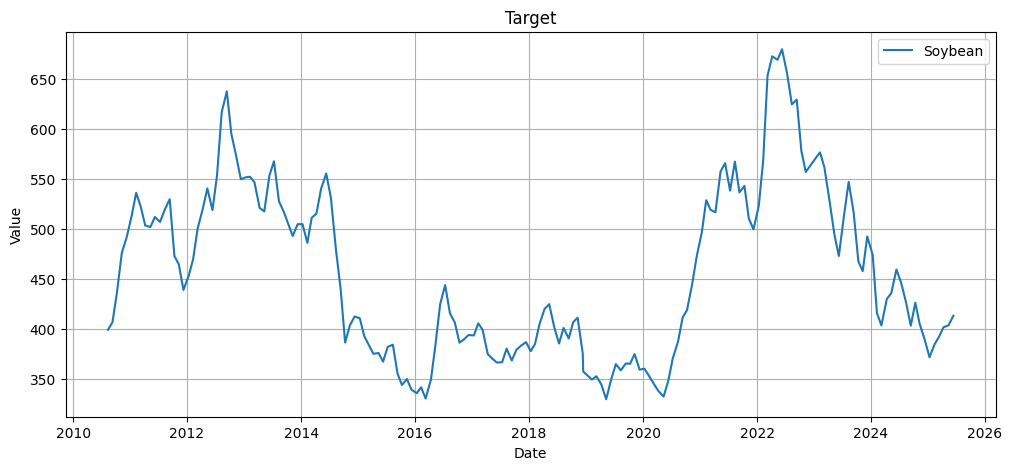

In [12]:
# Target visualization
plt.figure(figsize=(12, 5))
plt.plot(df_model['report_date'], df_model['soybean'], label='Soybean')
plt.title('Target')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

### 8. Time Series Decomposition

The following decomposition separates the **corn price series** into four components:  
- **Observed**: the original time series  
- **Trend**: the long-term progression of the series  
- **Seasonality**: repeating short-term cycles  
- **Residuals**: random noise or irregular components  

This breakdown is helpful to understand the underlying structure of the data and assess whether seasonality or trend components need to be explicitly modeled.


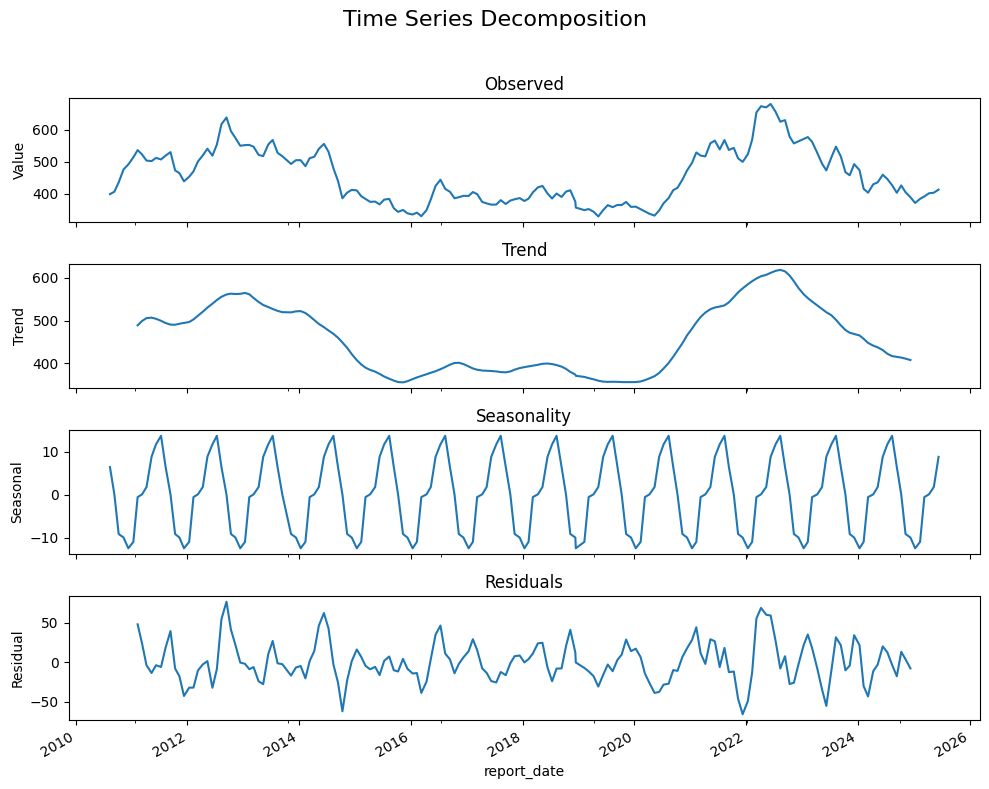

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose
result = seasonal_decompose(df_model.set_index('report_date')['soybean'], model='additive', period=12)

# Custom plot
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result.observed.plot(ax=axes[0], title='Observed')
axes[0].set_ylabel('Value')

result.trend.plot(ax=axes[1], title='Trend')
axes[1].set_ylabel('Trend')

result.seasonal.plot(ax=axes[2], title='Seasonality')
axes[2].set_ylabel('Seasonal')

result.resid.plot(ax=axes[3], title='Residuals')
axes[3].set_ylabel('Residual')

plt.suptitle('Time Series Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### 9. Stationarity Test (ADF)

Before fitting a SARIMAX model, it is essential to assess whether the target variable (`soybean`) is stationary. 
Many time series models assume that the statistical properties of the series (mean, variance, autocorrelation) remain constant over time.

To check this, we apply the Augmented Dickey-Fuller (ADF) test. The null hypothesis of the ADF test is that the series has a unit root, meaning it is non-stationary.

- If the p-value is **greater than 0.05**, we **fail to reject** the null hypothesis → the series is **non-stationary**, and differencing is required.
- If the p-value is **less than or equal to 0.05**, we **reject** the null hypothesis → the series is **stationary**, and can be used directly in modeling.


In [14]:
result = adfuller(target)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.1219426113757756
p-value: 0.23578338775604613


### 10. Differencing and Stationarity Re-check

Since the original `soybean` series was non-stationary (p-value > 0.05), we apply first-order differencing to remove any trends and stabilize the mean.

Differencing transforms the series by subtracting each value from its previous value. We then re-apply the Augmented Dickey-Fuller (ADF) test to check for stationarity.

- If the p-value is now **less than 0.05**, the differenced series is **stationary**, and we can use it with `d=1` in SARIMAX.
- Otherwise, additional transformations may be necessary.


ADF Statistic (differenced): -9.030195871589104
p-value: 5.4713023478553396e-15


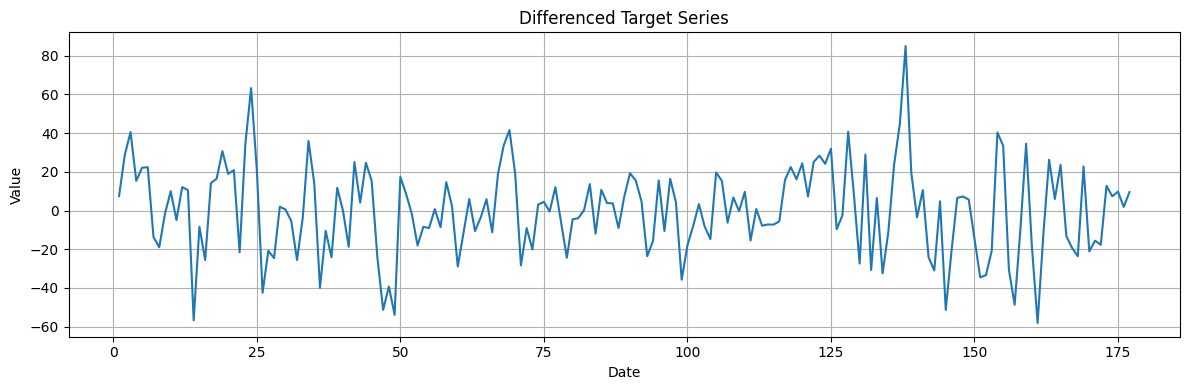

In [15]:
# Differencing
target_diff = target.diff().dropna()

# Augmented Dickey-Fuller test
result = adfuller(target_diff)
print("ADF Statistic (differenced):", result[0])
print("p-value:", result[1])

# Plot the differenced series
target_diff.plot(figsize=(12, 4), title="Differenced Target Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

After applying first-order differencing to the `soybean` series, we re-ran the ADF test. The resulting p-value is significantly below the 0.05 threshold.

This confirms that the differenced series is **stationary**, and we can proceed with SARIMAX modeling using `d=1`.


### 11. ACF and PACF Plots

To determine the appropriate values for the ARIMA parameters `p` (autoregressive) and `q` (moving average), we analyze the ACF and PACF plots of the differenced `soybean` series:

- **ACF (Autocorrelation Function)** helps identify the order `q` by showing correlations with lagged values. Significant spikes indicate the number of MA terms to include.
- **PACF (Partial Autocorrelation Function)** helps determine the order `p` by isolating the effect of each lag. Significant lags suggest how many AR terms to include.

These plots guide the choice of `p` and `q` for the SARIMAX model.


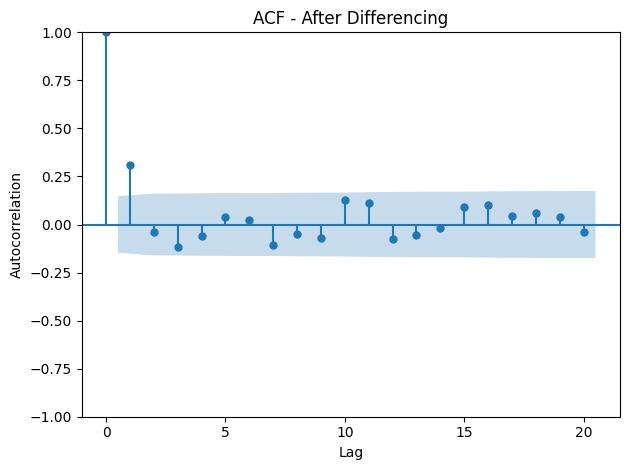

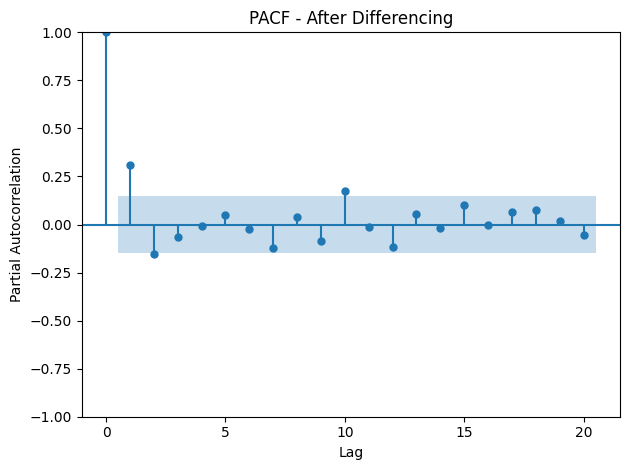

In [16]:
# ACF
plot_acf(target_diff, lags=20)
plt.title("ACF - After Differencing")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

# PACF
plot_pacf(target_diff, lags=20, method='ywm')
plt.title("PACF - After Differencing")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.tight_layout()
plt.show()


### ACF and PACF Interpretation

From the ACF and PACF plots of the differenced `soybean` series:

- **ACF** shows a significant spike only at lag 1, suggesting a Moving Average component of order 1 (`q = 1`).
- **PACF** also shows a significant spike only at lag 1, indicating an Autoregressive component of order 1 (`p = 1`).

Based on these results, we propose a SARIMAX model with parameters:  
`order = (1, 1, 1)` — using first-order differencing (`d = 1`) as previously determined.


### 12. Feature Correlation with Target (`soybean`)

To better understand the relationship between our target variable (`soybean`) and the available explanatory variables, we compute the Pearson correlation coefficient between `soybean` and each other feature in the dataset.

This bar chart displays how strongly each variable is linearly correlated with `soybean`:

- **Positive correlations** (blue bars) indicate that the variable tends to increase when corn prices increase.
- **Negative correlations** (red bars) suggest that the variable tends to move inversely to corn prices.

High positive correlations (e.g., `corn_quote` or `exports_corn_cy_unitedstates`) may indicate strong predictors of corn price movements. On the other hand, strongly negative correlations (e.g., `ending_stocks_corn_oy_unitedstates`) may represent downward pressure on prices due to high supply.

This insight guides us in selecting the most informative features to include as exogenous variables in the SARIMAX model.


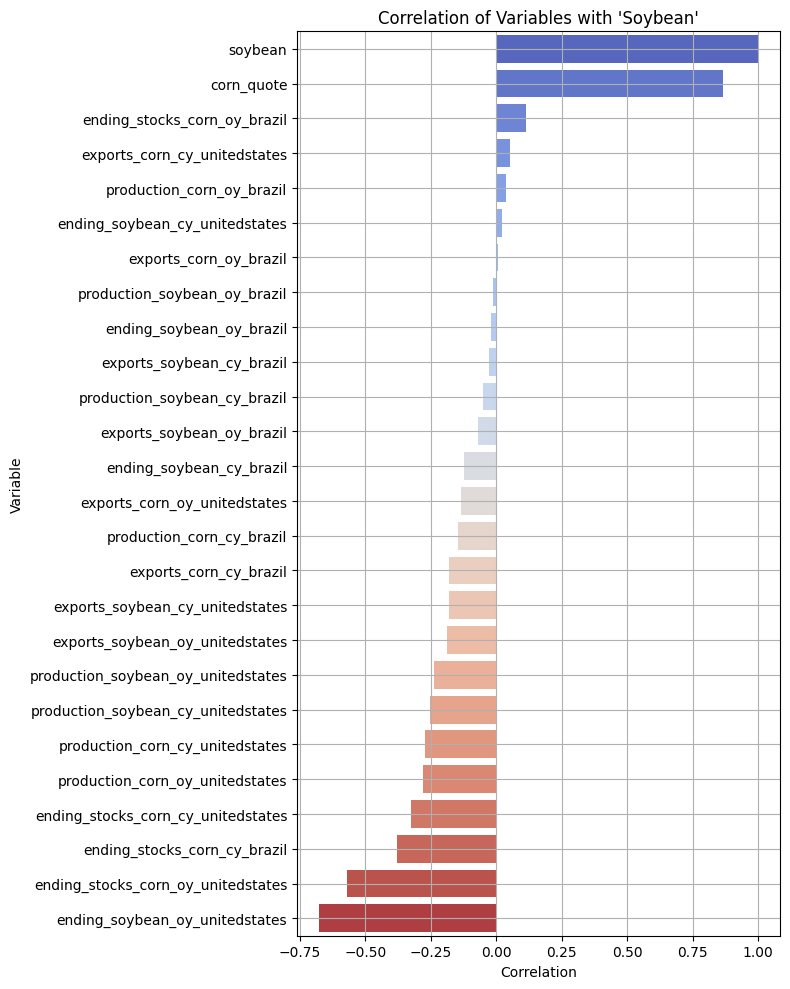

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation with target 'soybean'
corr_target = df_model.corr(numeric_only=True)["soybean"].sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(
    x=corr_target.values,
    y=corr_target.index,
    hue=corr_target.index, 
    palette="coolwarm",
    legend=False
)
plt.title("Correlation of Variables with 'Soybean'")
plt.xlabel("Correlation")
plt.ylabel("Variable")
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 13 – Heatmap of Multicollinearity Among Exogenous Variables

To ensure that the exogenous variables do not contain excessive multicollinearity, we generate a heatmap of Pearson correlations among them.

High correlations (close to ±1) indicate redundancy between variables, which can distort parameter estimation in regression-based time series models like SARIMAX.

In cases of strong multicollinearity, we may consider removing some variables or applying dimensionality reduction techniques like PCA.


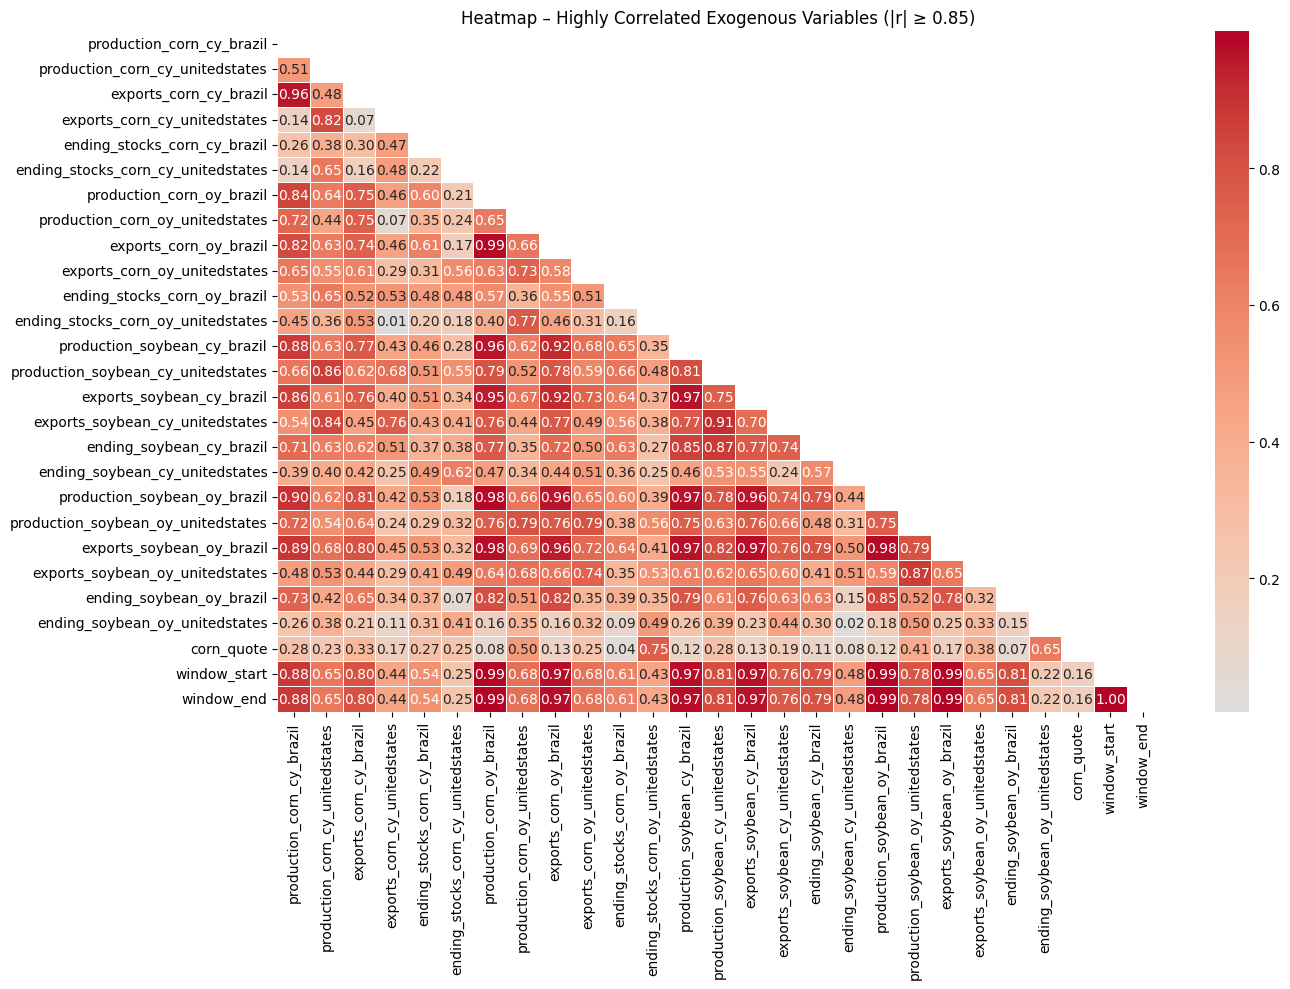

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude target and date columns
exclude_cols = ['report_date', 'soybean']
exog_vars = [col for col in df_model.columns if col not in exclude_cols]

# Compute absolute correlation matrix
corr_matrix = df_model[exog_vars].corr().abs()

# Mask the diagonal and lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Keep only high correlations (above threshold)
threshold = 0.85
high_corr = corr_matrix.where(mask)  # keep upper triangle only
high_corr = high_corr[high_corr >= threshold]

# Drop rows and cols where all values are NaN (i.e., no strong correlation)
filtered_vars = high_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Plot heatmap only for filtered variables
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix.loc[filtered_vars.index, filtered_vars.columns],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    mask=np.triu(np.ones_like(filtered_vars, dtype=bool))
)
plt.title("Heatmap – Highly Correlated Exogenous Variables (|r| ≥ 0.85)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 14. Lagged Correlation Analysis

To assess the predictive potential of exogenous variables, we calculate the correlation between each exogenous feature and the target variable (`soybean`) at different time lags (1 to 6 months).

This analysis does **not** generate new features yet — it is an exploratory step to:

- Identify which variables lead the corn price with useful predictive patterns
- Avoid future data leakage by ensuring that only past or current values are used in forecasting
- Guide the selection of shifted features for the modeling pipeline

Only features that show meaningful correlation at a specific lag will later be included as `exog.shift(x)` during model training.


In [19]:
lag_corr_table = test_lagged_correlation(df_model, target_col='soybean', date_col='report_date', max_lag=6)
top_lags_df = top_lagged_predictors(lag_corr_table)
display(top_lags_df)



,Variable,Lag (months),Signed Correlation,Absolute Correlation
0,corn_quote,1,0.854724,0.854724
25,ending_soybean_oy_unitedstates,2,-0.686336,0.686336
48,ending_stocks_corn_oy_unitedstates,1,-0.559191,0.559191
35,ending_stocks_corn_cy_brazil,6,-0.445848,0.445848
17,ending_soybean_cy_unitedstates,6,0.296044,0.296044
88,exports_soybean_cy_unitedstates,5,-0.285235,0.285235
36,ending_stocks_corn_cy_unitedstates,1,-0.274257,0.274257
108,production_corn_cy_unitedstates,1,-0.259490,0.259490
134,production_soybean_cy_unitedstates,3,-0.259270,0.259270
120,production_corn_oy_unitedstates,1,-0.259153,0.259153


### Interpretation of Lagged Correlation Results

The table above highlights the strength and direction of the correlation between each exogenous variable and the target (`soybean`) at various time lags. This analysis helps identify which features may serve as good predictors when shifted appropriately in time.

Key insights:

- **`corn_quote` (lag 1)** shows a **very strong positive correlation** with soybean prices. This suggests a lead-lag relationship where corn quotes prices may anticipate brazilian soybean paranaguá price movements — likely due to substitution effects between the two grains.
- **`ending_soybean_oy_unitedstates` (lag 2)** exhibits a **strong negative correlation**, indicating that expectations of future soybean stock abundance suppress current prices.

These findings support the selection of specific lagged variables to be included as exogenous features in the SARIMAX model. The actual feature construction (`.shift(lag)`) will be performed in the modeling notebook to avoid data leakage.
